In [1]:
import json
import os
import pandas as pd
from shoeboxer.schedules import default_schedules
from shoeboxer.batch import batch_sim
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from archetypal import settings
from lightning.pytorch import Trainer

from ml.surrogate import Surrogate
from ml.predict import predict_ubem
from weather.weather import extract
from ladybug.epw import EPW
# import multiple locator from matplotlib
from matplotlib.ticker import MultipleLocator

# Check if we are running on Windows or Linux using os
if os.name == "nt":
    settings.ep_version == "22.2.0"
    settings.energyplus_location = Path("C:/EnergyPlusV22-2-0")
else:
    settings.ep_version == "22.2.0"
    settings.energyplus_location = Path("/usr/local/EnergyPlus-22-2-0")

c:\tools\Anaconda3\envs\ml-for-bem-final\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package energy-pandas is out of date. Your version is 0.3.3, the latest is 0.3.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:

registry = "ml-for-building-energy-modeling/model-registry"
model = "Global UBEM Shoebox Surrogate with Combined TS Embedder"
tag = "v3"
resource = "model.ckpt"

surrogate = Surrogate.load_from_registry(registry, model, tag, resource)
surrogate.model.eval()

trainer = Trainer(
        accelerator="auto",
        devices="auto",
        strategy="auto",
        enable_progress_bar=True,
    )

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [3]:

config = {
    "FacadeMass": 1,
    "RoofMass": 1,
    "FacadeRValue": 4.88,
    "RoofRValue": 4.88,
    "SlabRValue": 4.88,
    "WindowUValue": 2.0,
    "WindowShgc": 0.75,
    "PeopleDensity": 0.025,
    "EquipmentPowerDensity": 2,
    "LightingPowerDensity": 2,
    "HeatingSetpoint": 19,
    "CoolingSetpoint": 25,
    "cop_heating": 1,
    "cop_cooling": 1,
    "VentilationMode": 1,
    "VentilationPerArea": 0.001,
    "VentilationPerPerson": 0.001,
    "EconomizerSettings": 0,
    "RecoverySettings": 0,
    "Infiltration": 0.0005,
    "wwr": 0.2,
    "roof_2_footprint": 1,
    "ground_2_footprint": 0,
    "orientation": 0,
    "width": 3,
    "height": 4,
    "perim_depth": 3.6,
    "core_depth": 6.4,
    "building_id": 0,
    "weight": 1,
    "template_idx": 0,
}

n_samples = 1
sweep_independent = "orientation"
sweep_min_val = 0
sweep_max_val = 3*np.pi/2
df = pd.DataFrame([config for _ in range(n_samples)])
df[sweep_independent] = np.linspace(sweep_min_val, sweep_max_val, n_samples)
df["building_id"] = range(n_samples)


for i in range(12):
    df[f"shading_{i}"] = 0

scheds = default_schedules[0]
sin_schedule = np.linspace(0,2*np.pi*365-1/24*2*np.pi,365*24)
sin_schedule = -np.cos(sin_schedule)/2 + 0.5
scheds = np.stack([sin_schedule]*3).reshape(3,8760)

# epw_path = "data/epws/city_epws_indexed/cityidx_0001_USA_NY-New York Central Prk Obs Belv.725033_TMY3.epw"
epw_path = "C:/ProgramData/Solemma/Common/WeatherData/EPW/USA_MA_Boston-Logan.Intl.AP.725090_TMYx.2004-2018.epw"

epw = EPW(epw_path)
results = batch_sim(
    features=df,
    timeseries=scheds,
    climate=epw_path,
)

climate = extract(epw)

shoebox_results, *_ = predict_ubem(trainer=trainer, surrogate=surrogate, features=df,schedules=scheds.reshape(1,3,8760), climate=climate,apply_cops=False, batch_size=32,)

INFO:shoeboxer.geometry_utils:New perimeter depth: 3.6
INFO:shoeboxer.geometry_utils:New core depth: 6.4
INFO:shoeboxer.geometry_utils:Shifting core origin to perimeter edge; moving -1.4 m in y axis
INFO:shoeboxer.geometry_utils:Updating adiabatic surfaces.
INFO:shoeboxer.geometry_utils:Maximum shading point is 0.0
INFO:shoeboxer.geometry_utils:Placing shading around center point [1.5 0. ]
INFO:ShoeBox:Building idf for data\sim_results\963dfb41-c424-4399-93e3-3dd9d4b5353b\963dfb41-c424-4399-93e3-3dd9d4b5353b.epjson
INFO:ShoeBox:EnergyPlus Starting
INFO:ShoeBox:EnergyPlus, Version 22.2.0-c249759bad, YMD=2023.11.17 12:58
INFO:ShoeBox:Converted input file format. Exiting.
INFO:ShoeBox:EnergyPlus Run Time=00hr 00min  0.13sec
INFO:ShoeBox:Command executed successfully.
C:\EnergyPlusV22-2-0\ExpandObjects.EXE #0-963dfb41-c424-4399-93e3-3dd9d4b5353b.idf: 3.00it [00:00, 8.78it/s]
C:\EnergyPlusV22-2-0\energyplus.exe 963dfb41-c424-4399-93e3-3dd9d4b5353b.idf: 55it [00:03, 14.46it/s]
INFO: You are 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  0.69it/s]


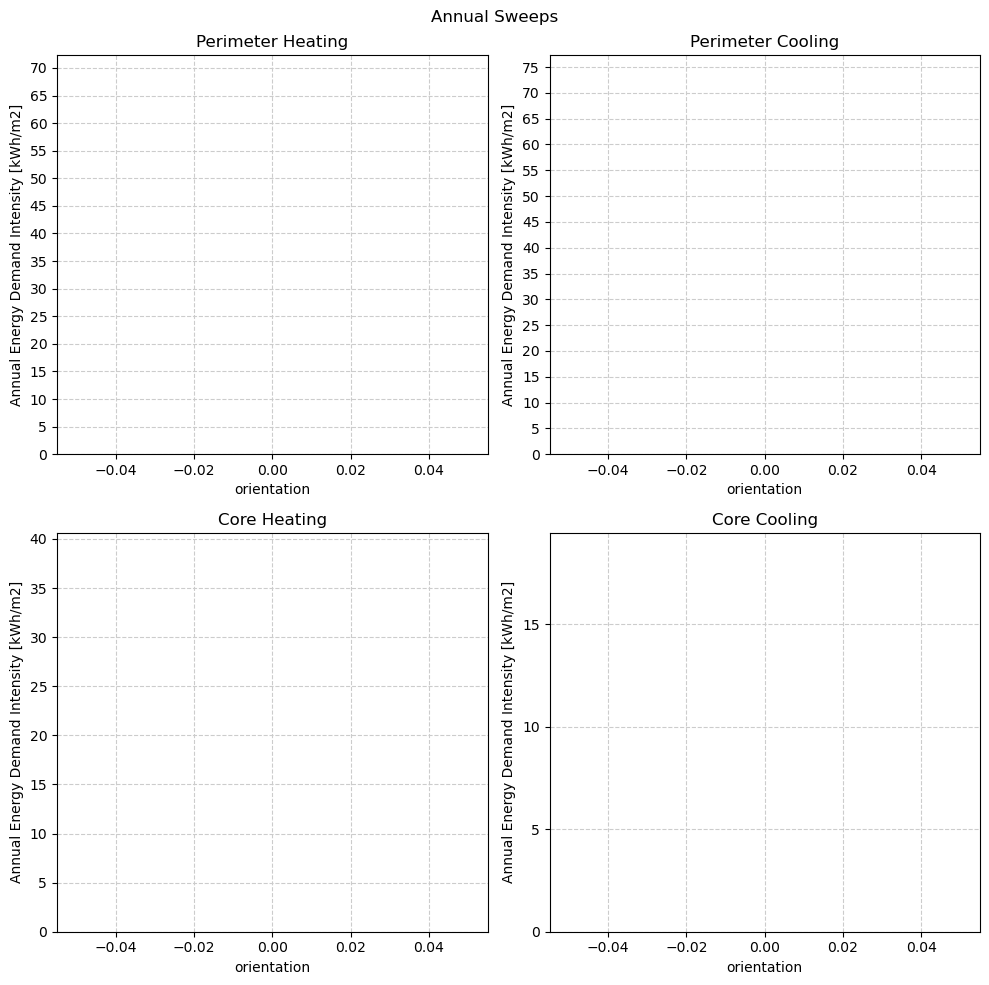

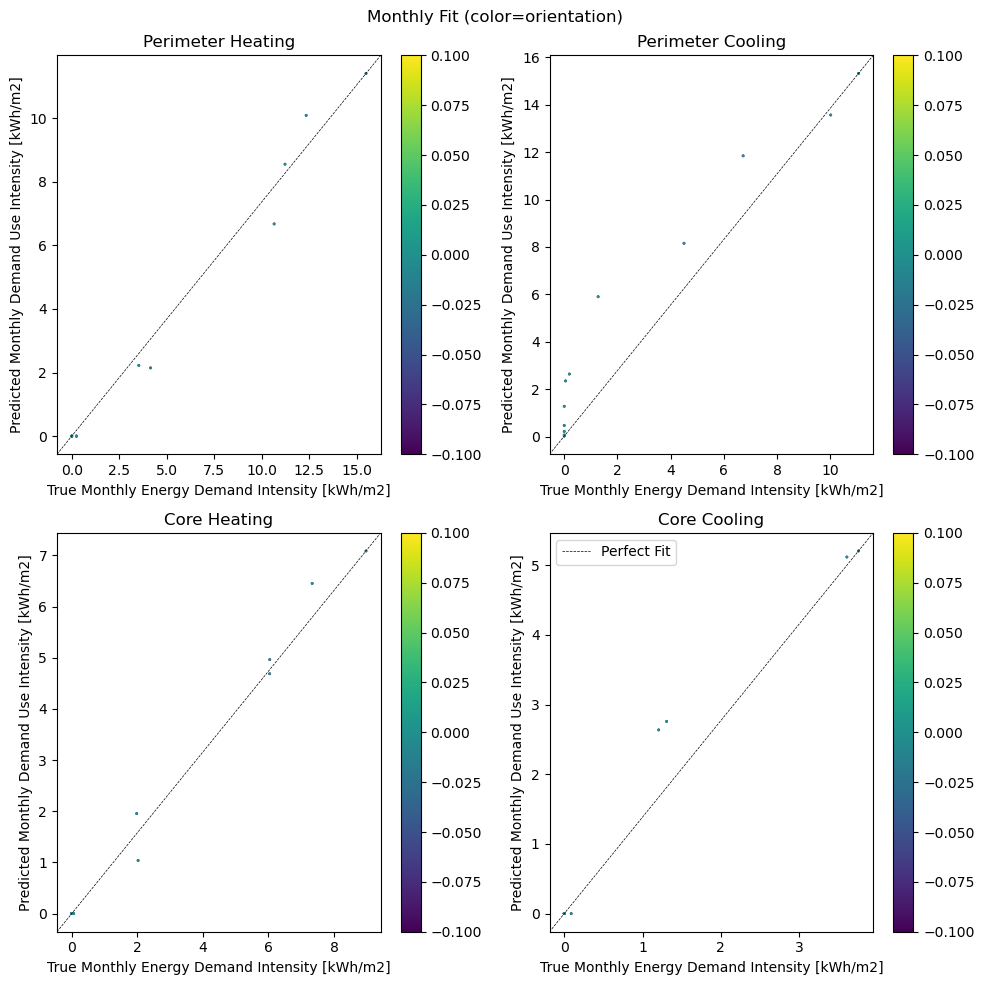

In [4]:
fig, axs = plt.subplots(2,2, figsize=(10,10))
for col, zone in [(0,"Perimeter"), (1,"Core")]:
    for row, end_use, color in [(0, "Heating", "#ef5954"),( 1, "Cooling", "#6595ef" )]:
        zone_use_true = results[zone][end_use].sum(axis=1)
        zone_use = shoebox_results[zone][end_use].sum(axis=1)
        axs[col,row].set_title(f"{zone} {end_use}")
        axs[col,row].plot(df[sweep_independent].values, zone_use_true, "-", label=f"EPlus", color=color)
        axs[col,row].plot(df[sweep_independent].values, zone_use, "--", label=f"Surrogate", color=color)
        axs[col,row].set_xlabel(sweep_independent)
        axs[col,row].set_ylabel("Annual Energy Demand Intensity [kWh/m2]")
        axs[col,row].set_ylim([0,1.25*max(zone_use_true.max(), zone_use.max())])
        # add grid lines every 5 units on y axis
        axs[col,row].yaxis.set_major_locator(MultipleLocator(5))
        # show grid lines
        axs[col,row].grid(which='major', color='#CCCCCC', linestyle='--')

plt.suptitle("Annual Sweeps")
fig.tight_layout()

fig, axs = plt.subplots(2,2, figsize=(10,10))
for col, zone in [(0,"Perimeter"), (1,"Core")]:
    for row, end_use, color in [(0, "Heating", "#ef5954"),( 1, "Cooling", "#6595ef" )]:
        zone_use_true = results[zone][end_use].values.flatten()
        zone_use = np.clip(shoebox_results[zone][end_use].values.flatten(),0,10000000)
        axs[col,row].set_title(f"{zone} {end_use}")
        axs[col,row].scatter(zone_use_true, zone_use,s=1, c=np.repeat(df[sweep_independent].values, 12))
        axs[col,row].set_xlabel("True Monthly Energy Demand Intensity [kWh/m2]")
        axs[col,row].set_ylabel("Predicted Monthly Demand Use Intensity [kWh/m2]")
        # show colorbar
        axs[col,row].plot([0, 1], [0, 1], transform=axs[col,row].transAxes, ls="--", c="k", lw=0.5, label="Perfect Fit")
        cbar = fig.colorbar(axs[col,row].scatter(zone_use_true, zone_use,s=1, c=np.repeat(df[sweep_independent].values, 12)))


plt.legend()
plt.suptitle(f"Monthly Fit (color={sweep_independent})")
fig.tight_layout()



In [5]:

shoebox_results["Perimeter"]["Cooling"].sum(axis=1).values, results["Perimeter"]["Cooling"].sum(axis=1).values

(array([61.815765], dtype=float32), array([33.81441166]))

In [14]:
shoebox_results["Perimeter"]["Cooling"].sum(axis=1).values, results["Perimeter"]["Cooling"].sum(axis=1).values

(array([49.696953], dtype=float32), array([32.3082759]))

In [18]:
from utils.constants import MechVentMode

MechVentMode(2.0).name

'OccupancySchedule'

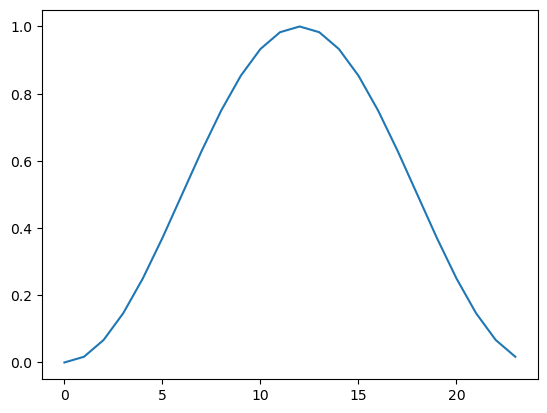

In [19]:
plt.plot(scheds[2,:24])

In [20]:
from shoeboxer.builder import ShoeboxConfiguration, ShoeBox

sb_config = ShoeboxConfiguration()
sb_config.width = config["width"]
sb_config.height = config["height"]
sb_config.adiabatic_partition_flag = 0
sb_config.perim_depth = config["perim_depth"]
sb_config.core_depth = config["core_depth"]
sb_config.wwr = config["wwr"]
sb_config.roof_2_footprint = config["roof_2_footprint"]
sb_config.ground_2_footprint = config["ground_2_footprint"]
sb_config.shading_vect = np.zeros(12)
sb_config.orientation = config["orientation"]
template_dict = config.copy()
template_dict["VentilationMode"] = 1
template_dict["schedules"] = scheds

sb = ShoeBox(
    name="with-vent",
    epw=epw_path,
    shoebox_config=sb_config,
    template_dict=template_dict,
    output_directory="data/sim_results/"
)
idf = sb.idf(run_simulation=False)

hourly_df, monthly_df = sb.simulate(idf=idf)

INFO:shoeboxer.geometry_utils:New perimeter depth: 3.6
INFO:shoeboxer.geometry_utils:New core depth: 6.4
INFO:shoeboxer.geometry_utils:Shifting core origin to perimeter edge; moving -1.4 m in y axis
INFO:shoeboxer.geometry_utils:Updating adiabatic surfaces.
INFO:shoeboxer.geometry_utils:Maximum shading point is 0.0
INFO:shoeboxer.geometry_utils:Placing shading around center point [1.5 0. ]
INFO:ShoeBox:Building idf for data\sim_results\with-vent.epjson
INFO:ShoeBox:EnergyPlus Starting
INFO:ShoeBox:EnergyPlus, Version 22.2.0-c249759bad, YMD=2023.11.17 13:18
INFO:ShoeBox:Converted input file format. Exiting.
INFO:ShoeBox:EnergyPlus Run Time=00hr 00min  0.15sec
INFO:ShoeBox:Command executed successfully.
C:\EnergyPlusV22-2-0\ExpandObjects.EXE #0-with-vent.idf: 3.00it [00:00, 8.16it/s]
C:\EnergyPlusV22-2-0\energyplus.exe with-vent.idf: 55it [00:03, 14.82it/s]
